# Hospital DTW Clustering

In [1]:
#%pip install tslearn

## imports

In [2]:
import os
import sys
sys.path.insert(0, os.path.abspath(
    os.path.join(os.path.dirname('__file__'), '..')))

import pandas as pd
import numpy as np
from cluster_dtw import *
import matplotlib.pyplot as plt
from src.features.meteorological_features import MeteorologicalFeatures
from src.features.air_quality_features import AirQualityFeatures
from src.features.hopital_features import HopitalFeatures
from src.features.epidemiological_features import EpidemiologicalFeatures
from src.features.google_trend_features import GoogleTrendFeatures
from src.features.sociological_features import SociologicalFeatures
from src.features.sports_features import SportsCompetitionFeatures
from src.features.traffic_features import TrafficFeatures
from src.features.population_features import PopulationFeatures
from src.location.location import Location, ETAB_NAMES

/Users/julienaudoux/Desktop/WORK(lab)/forecasting_models/.venv/lib/python3.10/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


## Settings

In [3]:
start_date = "2019-01-01"
end_date = "2023-12-31"

DATA_DIR = '../data/features/'

SAVE_PLOT_DIR = None # '../../result_clusters/endogenous/'

#ETABS = ETAB_NAMES
ETABS = [etab[1] for etab in ETAB_NAMES]
#ETABS = ['CHU Dijon', 'HNFC', 'CH Beaune']
#ETABS = ['CH Chaumont']

EXOGENOUS = False
ENDOGENOUS = True


exogenous_features = []
endogenous_features = []

if EXOGENOUS:
    exogenous_features = [
        AirQualityFeatures(name='airquality'),
        MeteorologicalFeatures(name='meteorological'),
        EpidemiologicalFeatures(name='epidemiological'),
        GoogleTrendFeatures(name='googletrend'),
        SociologicalFeatures(name='sociological'),
        SportsCompetitionFeatures(name='sportscompetition'),
        TrafficFeatures(name='traffic'),
        PopulationFeatures(name='population')
    ]

if ENDOGENOUS:
    endogenous_features = [
        HopitalFeatures(name='hopital', include_hnfc_moving=False, include_nb_hospit=False)
    ]


features = exogenous_features + endogenous_features

date_range = pd.date_range(start=start_date, end=end_date, freq="1D")



## Functions

In [4]:
def air_avg(df: pd.DataFrame):
    for name in ['NO2', 'PM10', 'PM25', 'O3']:
        # Filter columns that start with name +"_"
        name_columns = [col for col in df.columns if col.startswith(name + "_")]
        # Check if there is only one name + "_" column
        if len(name_columns) == 1:
            # If only one column, copy its values to the name + '_avg' column
            df[name + '_avg'] = df[name_columns[0]]
        elif len(name_columns) > 1:
            # If more than one column, calculate the row-wise mean
            df[name + '_avg'] = df[name_columns].mean(axis=1)
        # Drop the name + "_" columns
        df = df.drop(columns=name_columns)
    return df

In [5]:
def plot_time_series(time_series, date_range, labels, value='Value', title='etabs', cluster=''):
    # Plot all three time series
    plt.figure(figsize=(12, 6))
    for i in range(len(labels)):
        plt.plot(date_range, time_series[i], label=labels[i], linewidth=0.5)

    # Add labels, title, and legend
    plt.xlabel('Time')
    plt.ylabel(value)
    title = f'Comparison of {title} {value}'
    plt.title(title)
    plt.legend()

    plt.grid(True)
    if SAVE_PLOT_DIR != None: plt.savefig(SAVE_PLOT_DIR + f"{title}{cluster}.png", format="png", dpi=300)
    plt.show()

In [6]:
def subplots_time_series(time_series, date_range, labels, value='Value', cluster=''):
    plt.figure(figsize=(10, 15))

    # Subplot for ts
    for i in range(len(labels)):
        plt.subplot(len(labels), 1, i+1)
        plt.plot(date_range, time_series[i], label=labels[i], linewidth=0.5)
        title = f'{labels[i]} {value}'
        plt.title(title)
        plt.grid(True)

    plt.tight_layout()
    if SAVE_PLOT_DIR != None: plt.savefig(SAVE_PLOT_DIR + f"subplots_{value}{cluster}.png", format="png", dpi=300)
    plt.show()

## Loading Data

In [7]:
datasets = []
for etab in ETABS:
    loc = Location(etab)
    data = pd.DataFrame()
    print(loc)
    for i in range(len(features)):
        #if i != 7: continue
        if type(features[i]) == AirQualityFeatures:
            data = data.merge(air_avg(features[i].fetch_data_function(location=loc, feature_dir=f'{DATA_DIR}{features[i].name}features/').loc[start_date:end_date]), left_index=True, right_index=True, how="outer")
        else:
            data = data.merge(features[i].fetch_data_function(location=loc, feature_dir=f'{DATA_DIR}{features[i].name}features/', start_date=start_date, stop_date=end_date).loc[start_date:end_date], left_index=True, right_index=True, how="outer")
    datasets.append(data)
#datasets[0]

CH Beaune is located at Beaune, 21054, Côte-d'Or, Bourgogne-Franche-Comté
CH Semur is located at Semur-en-Auxois, 21603, Côte-d'Or, Bourgogne-Franche-Comté
CH Chatillon Montbard is located at Châtillon-sur-Seine, 21154, Côte-d'Or, Bourgogne-Franche-Comté
HNFC is located at Trévenans, 90097, Territoire de Belfort, Bourgogne-Franche-Comté
CHU Besançon is located at Besançon, 25056, Doubs, Bourgogne-Franche-Comté
CH privé Dijon is located at Dijon, 21231, Côte-d'Or, Bourgogne-Franche-Comté
CHU Dijon is located at Dijon, 21231, Côte-d'Or, Bourgogne-Franche-Comté
CH Langres is located at Langres, 52269, Haute-Marne, Grand Est
CH Chaumont is located at Chaumont, 52121, Haute-Marne, Grand Est


## Plotting datasets Totals

In [86]:
# ts = []
# for etab in ETABS:
#     ts.append(datasets[ETABS.index(etab)]['Total_' + etab])

In [87]:
#plot_time_series(ts, date_range, ETABS, value='Total')

In [88]:
#subplots_time_series(ts, date_range, ETABS, value='Total')

## DTW Clustering

In [89]:
clusters, dtw_matrix, n_clusters = cluster_dtw(datasets, scale=True, verbose=True)
clusters_etab = output_clusters([etab for etab in ETABS], clusters)

Number of clusters: 2, Silhouette Score: 0.864
Number of clusters: 3, Silhouette Score: 0.471
Number of clusters: 4, Silhouette Score: 0.339
Number of clusters: 5, Silhouette Score: 0.334
Number of clusters: 6, Silhouette Score: 0.213
Number of clusters: 7, Silhouette Score: 0.128
Number of clusters: 8, Silhouette Score: 0.084

Optimal number of clusters: 2 -> [0 0 0 1 1 0 1 0 0]
Cluster 0
['CH Beaune', 'CH Semur', 'CH Chatillon Montbard', 'CH privé Dijon', 'CH Langres', 'CH Chaumont']
Cluster 1
['HNFC', 'CHU Besançon', 'CHU Dijon']


## Plotting the results

In [90]:
#plot_pca(dtw_matrix, n_clusters, ETABS)

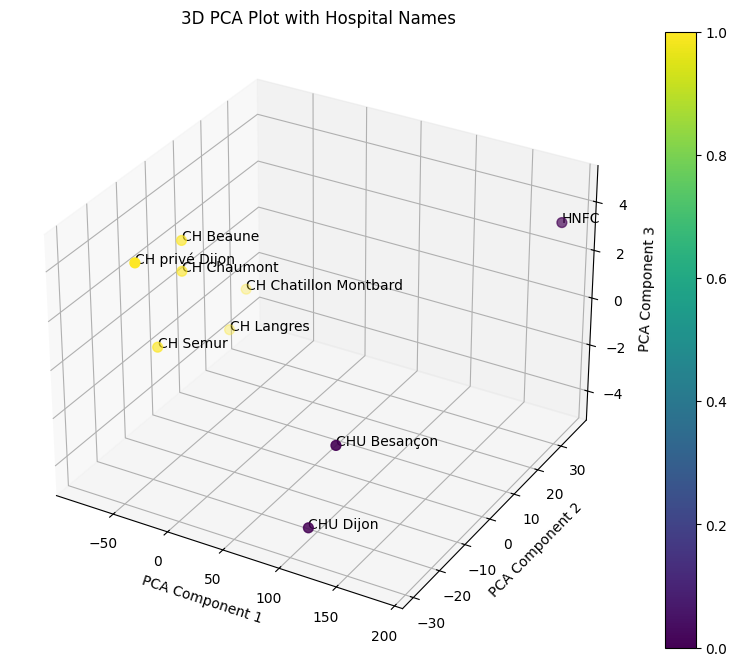

In [91]:
plot_pca_3D(dtw_matrix, n_clusters, ETABS, save_dir=SAVE_PLOT_DIR)

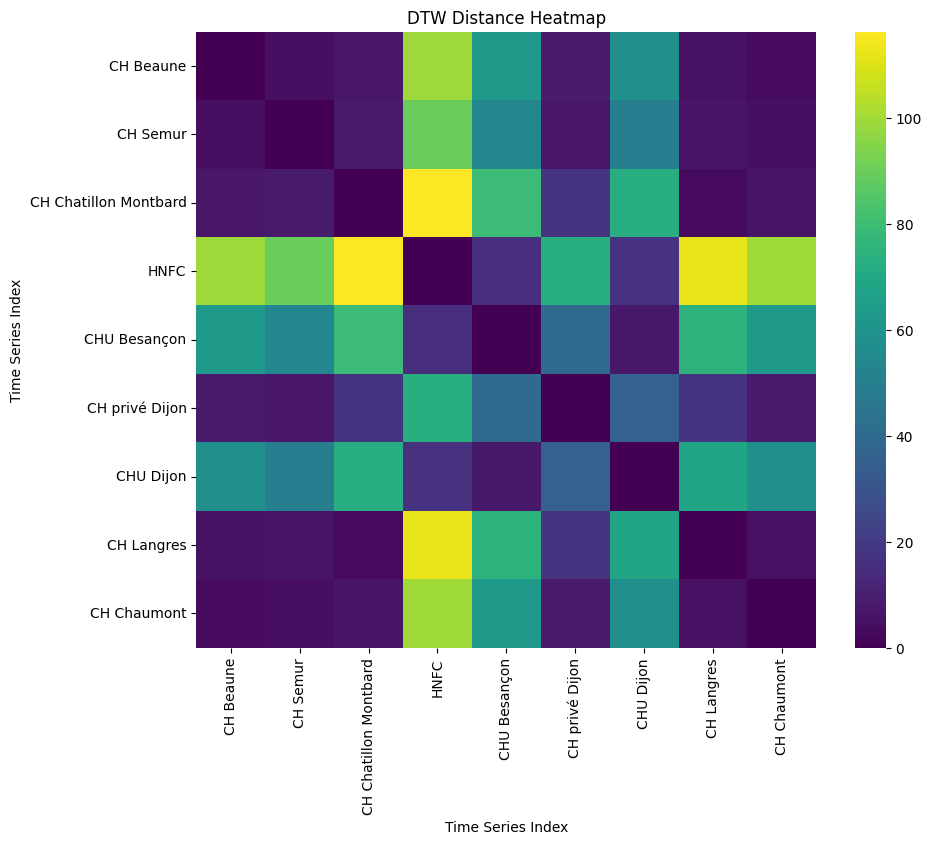

In [92]:
plot_heatmap(dtw_matrix, ETABS, save_dir=SAVE_PLOT_DIR)

### Plotting Total signals in clusters

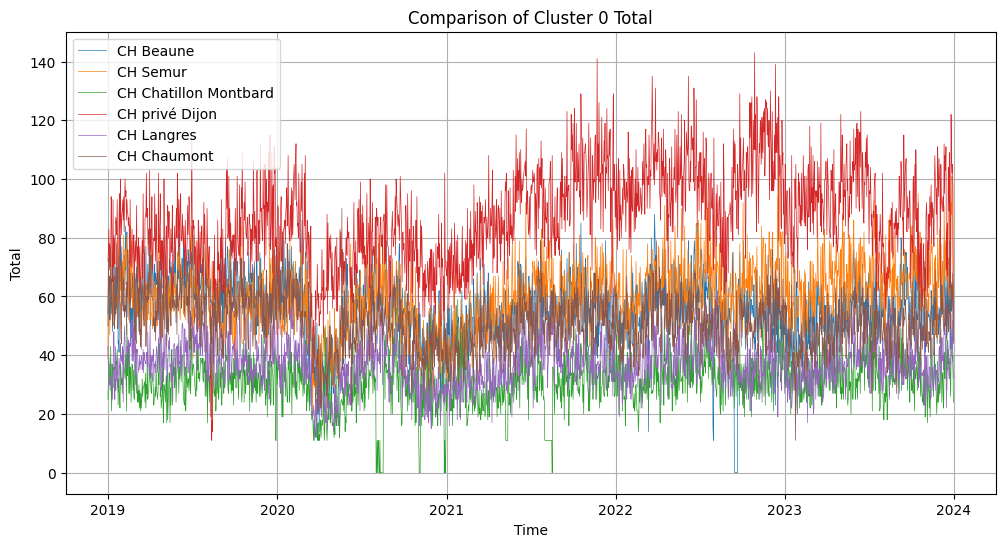

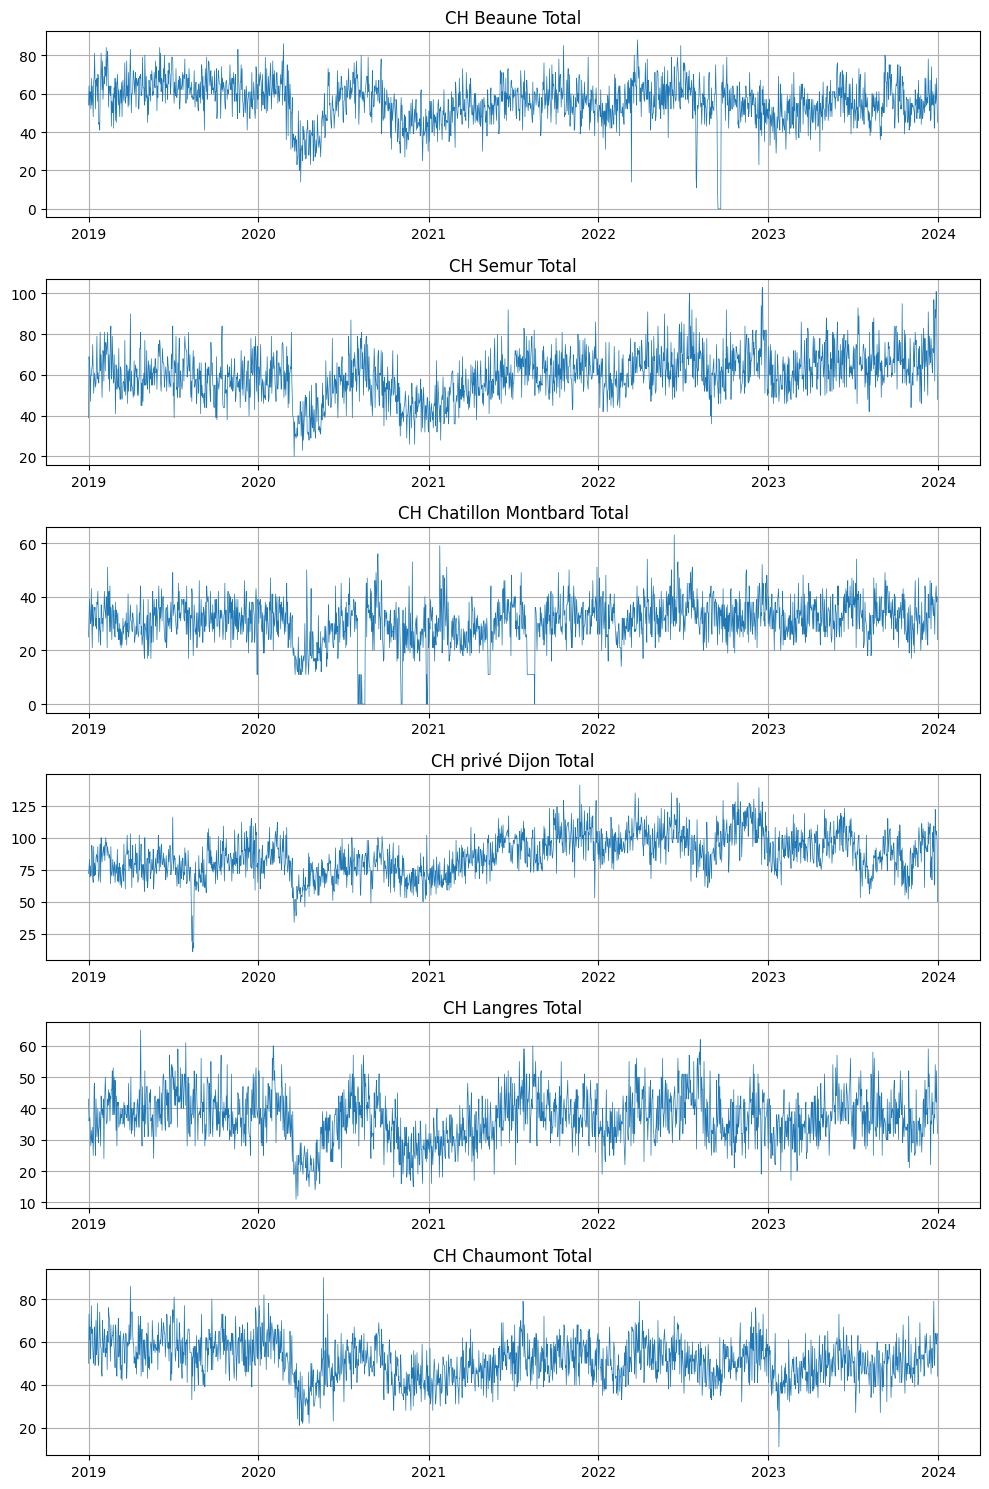

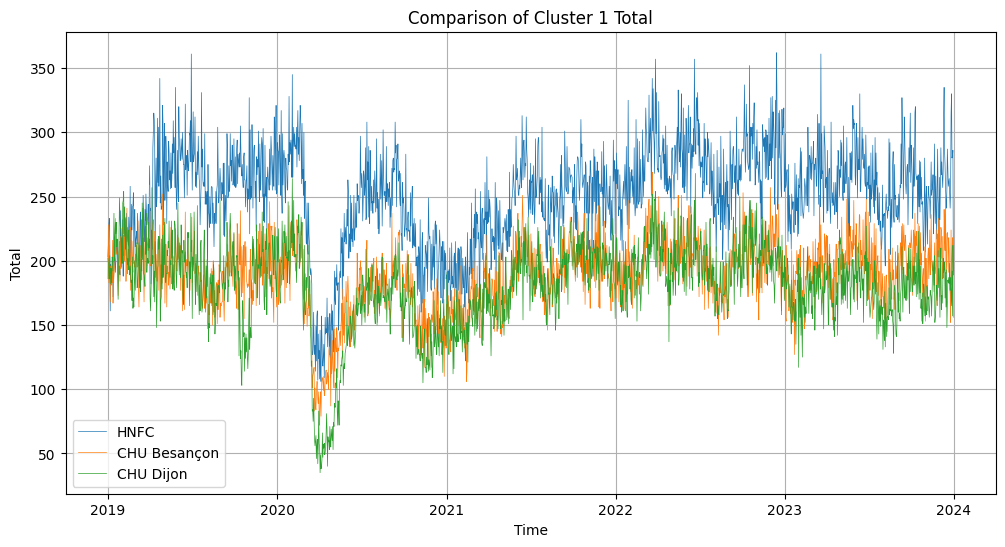

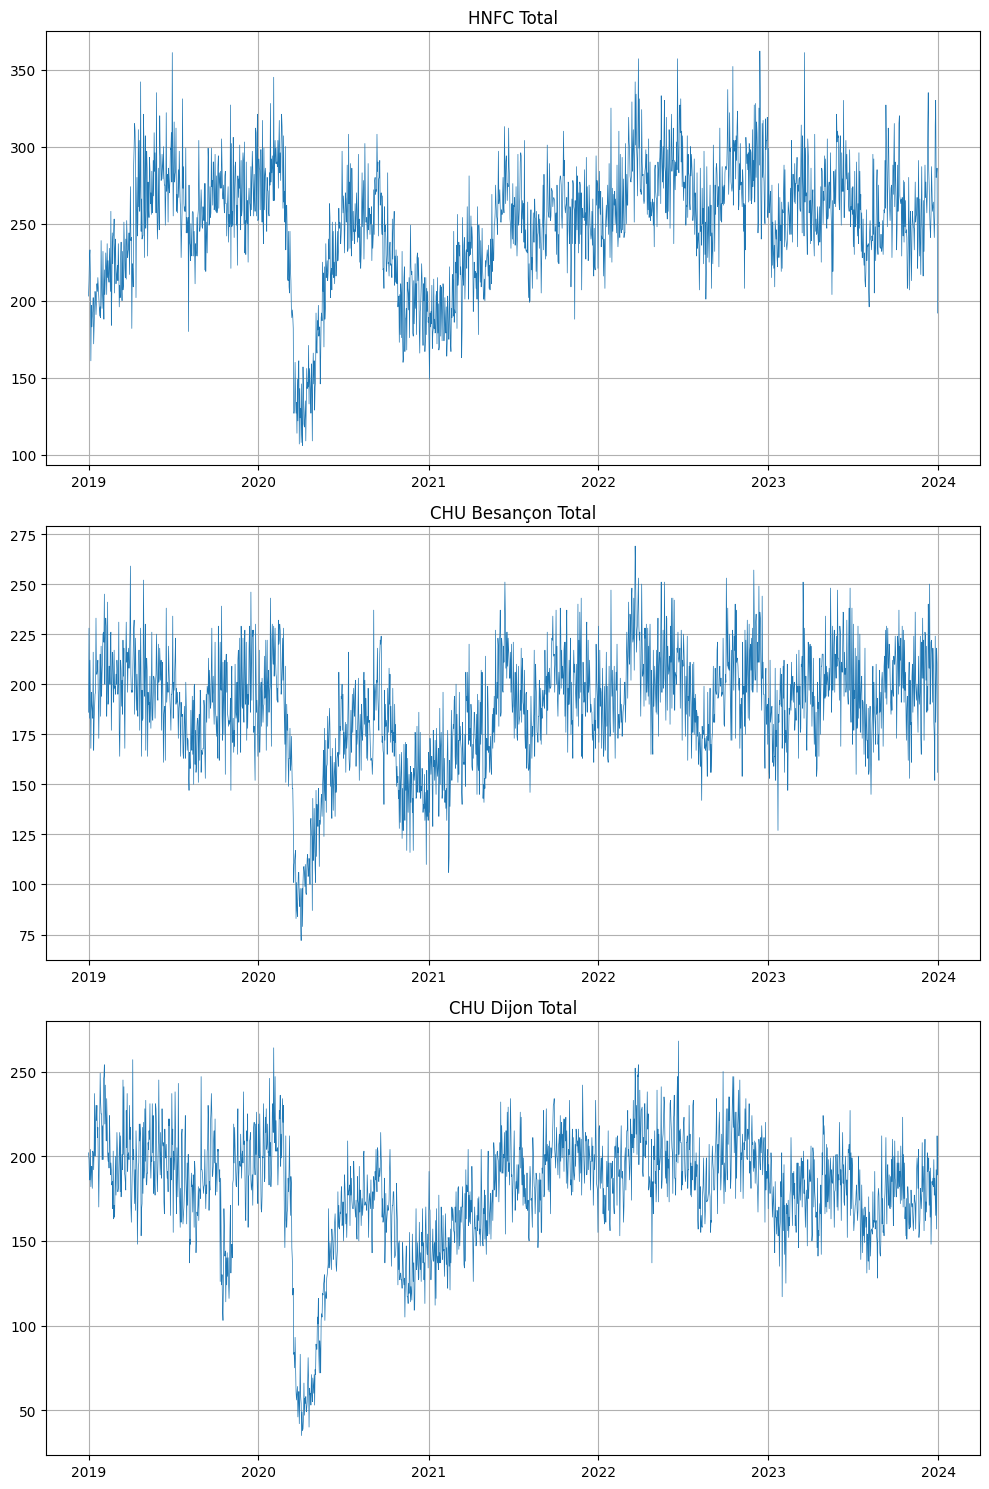

In [93]:
if ENDOGENOUS:
    for cluster in clusters_etab:
            ts = []
            for etab in clusters_etab[cluster]:
                ts.append(datasets[ETABS.index(etab)]['Total_' + etab])
            plot_time_series(ts, date_range, clusters_etab[cluster], value='Total', title='Cluster ' + str(cluster), cluster=str(cluster))
            subplots_time_series(ts, date_range, clusters_etab[cluster], value='Total', cluster=str(cluster))

### Plotting Total average in clusters

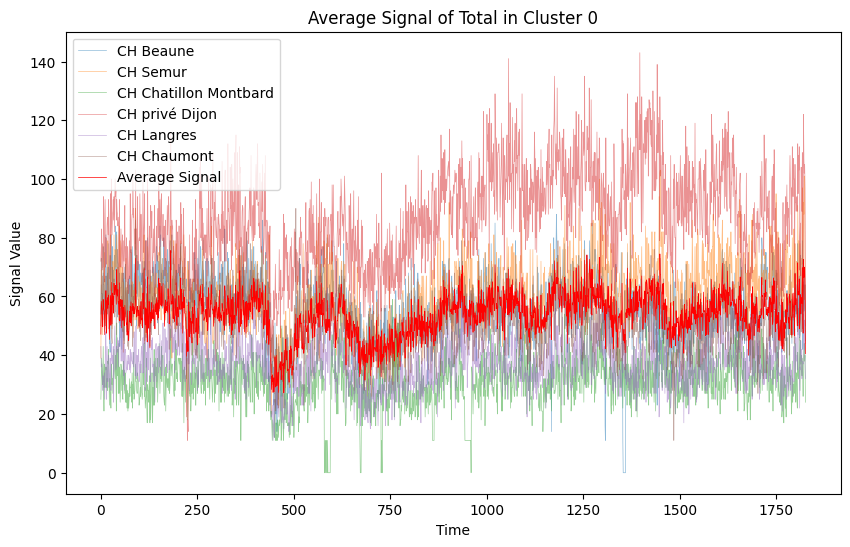

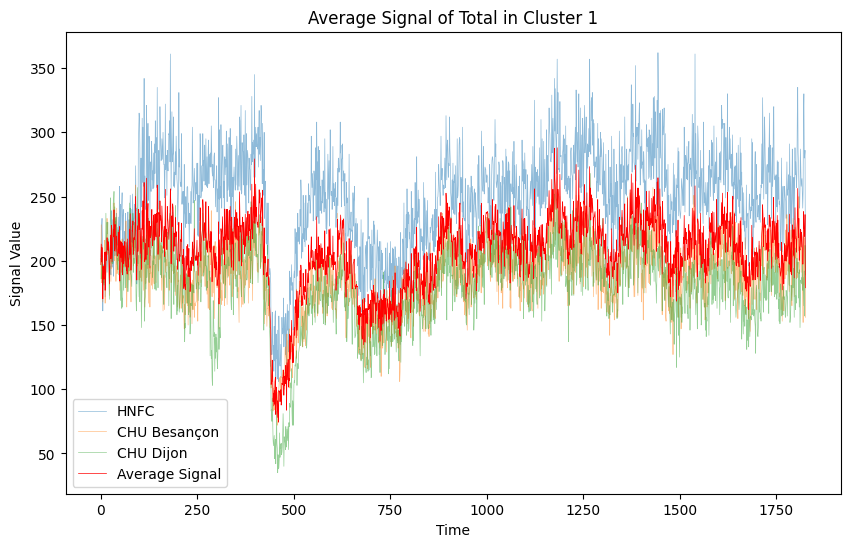

In [94]:
dico = {}
if ENDOGENOUS:
    for cluster in clusters_etab:
        df = pd.DataFrame()
        for etab in clusters_etab[cluster]:
            df[etab] = datasets[ETABS.index(etab)]['Total_' + etab]
        dico[cluster] = df


    for key in dico:
        average_signal = dico[key].mean(axis=1 )
        plt.figure(figsize=(10, 6))
        for etab in dico[key]:
            dico[key][etab].plot(label=etab, linewidth=0.5, alpha=0.5)
        average_signal.plot(label='Average Signal', color='r', linewidth=0.5)
        
        plt.xlabel('Time')
        plt.ylabel('Signal Value')
        title = 'Average Signal of Total in Cluster ' + str(key)
        plt.title(title)
        plt.legend()
        if SAVE_PLOT_DIR != None: plt.savefig(SAVE_PLOT_DIR + f"{title}.png", format="png", dpi=300)
        plt.show()


